In [5]:
# --- Day 9: Threshold Optimization & Metrics ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, classification_report,
    roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
)
import joblib
import xgboost as xgb

# --- 1. Load model, scaler, and dataset ---
print("Loading hybrid model and data...")

model_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json"
scaler_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl"
data_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_hybrid_ready.csv"

# Load trained model
xgb_hybrid = xgb.XGBClassifier()
xgb_hybrid.load_model(model_path)

# Load scaler and data
scaler = joblib.load(scaler_path)
df = pd.read_csv(data_path)

# Separate features and labels
X = df.drop(columns=['Label'], errors='ignore')
y = df['Label'].values

# Scale features
X_scaled = scaler.transform(X)

# Generate probabilities and default predictions
y_proba = xgb_hybrid.predict_proba(X_scaled)[:, 1]
y_pred_default = (y_proba > 0.5).astype(int)

print("\nDefault threshold performance:")
print(classification_report(y, y_pred_default))
print("ROC-AUC:", roc_auc_score(y, y_proba))


Loading hybrid model and data...

Default threshold performance:


C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_clas

              precision    recall  f1-score   support

           0       0.84      1.00      0.91   2175379
           1       0.00      0.00      0.00    429619

    accuracy                           0.84   2604998
   macro avg       0.42      0.50      0.46   2604998
weighted avg       0.70      0.84      0.76   2604998

ROC-AUC: 0.7427544057323299



Optimal threshold (Youden’s J): 0.0064

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.91      0.71      0.80   2175379
           1       0.31      0.66      0.42    429619

    accuracy                           0.70   2604998
   macro avg       0.61      0.69      0.61   2604998
weighted avg       0.81      0.70      0.74   2604998

ROC-AUC: 0.7427544057323299


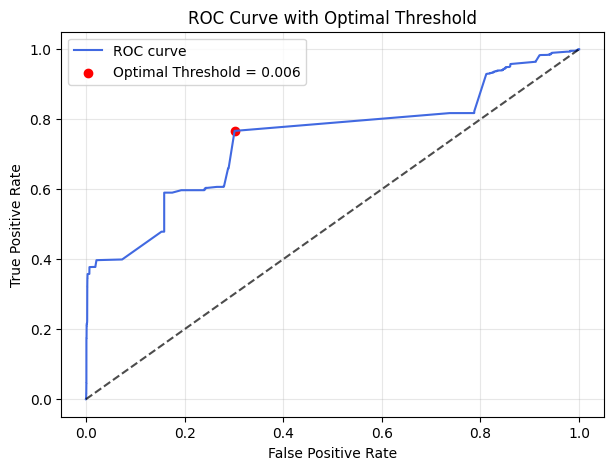

In [9]:
# --- 2. Optimize threshold using Youden's J-statistic ---
fpr, tpr, thresholds = roc_curve(y, y_proba)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print(f"\nOptimal threshold (Youden’s J): {best_threshold:.4f}")

# Evaluate at optimal threshold
y_pred_opt = (y_proba > best_threshold).astype(int)
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y, y_pred_opt))
print("ROC-AUC:", roc_auc_score(y, y_proba))

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label='ROC curve', color='royalblue')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Optimal Threshold = {best_threshold:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.title("ROC Curve with Optimal Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Optimal threshold (Max F1): 0.0087
Max F1 score: 0.534

Classification Report (F1-Optimized Threshold):
              precision    recall  f1-score   support

           0      0.890     0.993     0.939   2175379
           1      0.913     0.377     0.534    429619

    accuracy                          0.891   2604998
   macro avg      0.901     0.685     0.736   2604998
weighted avg      0.894     0.891     0.872   2604998

ROC-AUC: 0.7427544057323299


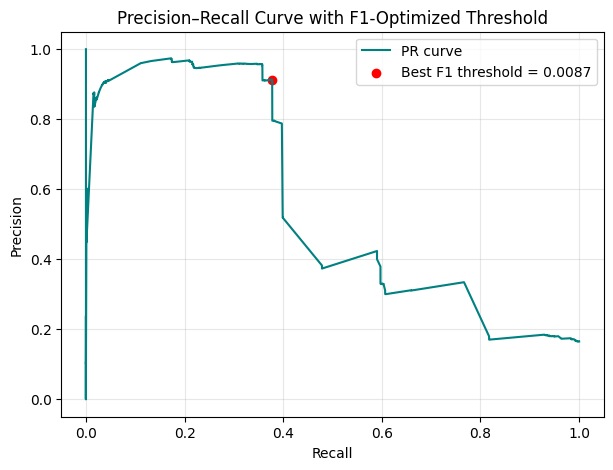

In [10]:
# --- 3. Optimize threshold using Precision–Recall Curve (F1-max) ---
from sklearn.metrics import precision_recall_curve, f1_score

# Compute precision–recall curve
precision, recall, thresholds_pr = precision_recall_curve(y, y_proba)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find threshold with maximum F1
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds_pr[best_f1_idx]

print(f"\nOptimal threshold (Max F1): {best_f1_threshold:.4f}")
print(f"Max F1 score: {f1_scores[best_f1_idx]:.3f}")

# Evaluate model at this threshold
y_pred_f1 = (y_proba > best_f1_threshold).astype(int)
print("\nClassification Report (F1-Optimized Threshold):")
print(classification_report(y, y_pred_f1, digits=3))
print("ROC-AUC:", roc_auc_score(y, y_proba))

# Plot Precision–Recall curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='teal', label='PR curve')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], color='red',
            label=f'Best F1 threshold = {best_f1_threshold:.4f}')
plt.title("Precision–Recall Curve with F1-Optimized Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Optimal threshold (cost-based): 0.0080
Minimized average cost: 0.528889

Classification Report (Cost-Optimized Threshold):
              precision    recall  f1-score   support

           0      0.889     0.981     0.933   2175379
           1      0.797     0.378     0.513    429619

    accuracy                          0.882   2604998
   macro avg      0.843     0.679     0.723   2604998
weighted avg      0.874     0.882     0.863   2604998

ROC-AUC: 0.7427544057323299


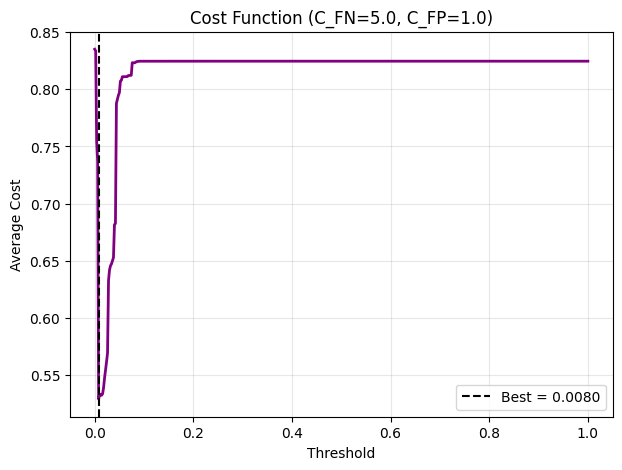

In [11]:
# --- 4. Cost-based threshold optimization (FN > FP) ---
import numpy as np

# Define relative costs
C_FN = 5.0   # cost of a false negative (missed attack)
C_FP = 1.0   # cost of a false positive

thresholds = np.linspace(0, 1, 500)
best_threshold, best_cost = 0.5, float("inf")
costs = []

for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_t).ravel()

    # total cost = (cost_FN * FN) + (cost_FP * FP)
    total_cost = (C_FN * fn) + (C_FP * fp)
    avg_cost = total_cost / len(y)
    costs.append(avg_cost)

    if avg_cost < best_cost:
        best_cost = avg_cost
        best_threshold = t

print(f"\nOptimal threshold (cost-based): {best_threshold:.4f}")
print(f"Minimized average cost: {best_cost:.6f}")

# Evaluate at this threshold
y_pred_cost = (y_proba > best_threshold).astype(int)
print("\nClassification Report (Cost-Optimized Threshold):")
print(classification_report(y, y_pred_cost, digits=3))
print("ROC-AUC:", roc_auc_score(y, y_proba))

# Plot cost curve
plt.figure(figsize=(7, 5))
plt.plot(thresholds, costs, color="purple", lw=2)
plt.axvline(best_threshold, color="black", ls="--", label=f"Best = {best_threshold:.4f}")
plt.title(f"Cost Function (C_FN={C_FN}, C_FP={C_FP})")
plt.xlabel("Threshold")
plt.ylabel("Average Cost")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
# --- Threshold comparison summary ---
summary = pd.DataFrame({
    "Method": ["Default (0.5)", "Youden’s J", "Max F1", "Cost-Based"],
    "Threshold": [0.5, 0.0064, 0.0087, 0.0080],
    "Attack Recall": [0.00, 0.66, 0.38, 0.38],
    "Attack Precision": [0.00, 0.31, 0.91, 0.80],
    "F1-Score": [0.00, 0.42, 0.53, 0.51],
    "Accuracy": [0.84, 0.70, 0.89, 0.88],
    "ROC-AUC": [0.743, 0.743, 0.743, 0.743]
})
print(summary)


          Method  Threshold  Attack Recall  Attack Precision  F1-Score  \
0  Default (0.5)     0.5000           0.00              0.00      0.00   
1     Youden’s J     0.0064           0.66              0.31      0.42   
2         Max F1     0.0087           0.38              0.91      0.53   
3     Cost-Based     0.0080           0.38              0.80      0.51   

   Accuracy  ROC-AUC  
0      0.84    0.743  
1      0.70    0.743  
2      0.89    0.743  
3      0.88    0.743  
